In [4]:
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.io.shapereader as shpreader


import matplotlib.backends.backend_pdf as pdf
import matplotlib.font_manager as mfm
import matplotlib.patches as patches

In [5]:
# more setup
cm = 1/2.54
a4_landscape = (29.7*cm,21*cm)
a4_portrait = (21*cm,29.7*cm)
a5_landscape = (21*cm,14.8*cm)
a5_portrait = (14.8*cm,21*cm)

iceland_extent = (-25.356,-11.997,62.472,67.458)
capital_region_extent = (-22.769,-21.110, 63.729, 64.373)

fname = '/Users/odinndagur/Downloads/gadm36_ISL_shp/gadm36_ISL_2.shp'

In [6]:
# ignore unimportant warning that comes up
import warnings
from shapely.errors import ShapelyDeprecationWarning

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [24]:
# clean data and make a dataframe and bbox
import json
import numpy as np

with open('pools.json','r') as f:
    data = json.load(f)

for pool in data:
    pool['address'] = pool['address'].strip()
    if(len(pool['coordinates']) > 0):
        pool['latitude'], pool['longitude'] = float(pool['coordinates'].split(',')[0]), float('-' + pool['coordinates'].split(',')[1])

dataframe = pd.DataFrame(data=data)

# BBox = (df.longitude.min(),   df.longitude.max(),      
#          df.latitude.min(), df.latitude.max())
# print(dataframe)


In [ ]:
def lon_to_x(lon,xmin,xmax,width,normalized=False):
    if normalized:
        return ((lon-xmin) / ((xmax-xmin)/width))/width
    return (lon-xmin) / ((xmax-xmin)/width)

def lat_to_y(lat,ymin,ymax,height,normalized=False):
    if normalized:
        return ((lat-ymin) / ((ymax-ymin)/height))/height
    return (lat-ymin) / ((ymax-ymin)/height)

def get_xy_normalized(lon,lat,min_lon,max_lon,min_lat,max_lat,width,height):
    # get lon,lat as x,y coordinates normalized from 0.0-1.0
    return lon_to_x(lon,min_lon,max_lon,width,normalized=True),lat_to_y(lat,min_lat,max_lat,height,normalized=True)

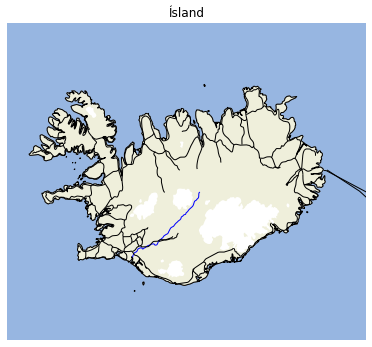

In [25]:
df = dataframe
fig = plt.figure(figsize=a5_landscape)
fig.set_gid('ysti-rammi')

# ax = fig.add_subplot(1,1,1,projection=ccrs.Mercator())
ax = plt.axes(projection=ccrs.Mercator())

# ax.set_global()
region_extent = iceland_extent
ax.set_extent(region_extent, crs=ccrs.PlateCarree())
ax.set_title('Ísland')
ax.set_gid('island')

# drop points from df if out of range of region_extent
# print(len(df))
# print(region_extent,df.latitude.min(),df.latitude.max(),df.longitude.min(),df.longitude.max())
# (-22.769, -21.11, 63.729, 64.373) 66.5393464707103 63.41745892482214 -13.688923893115202 -23.98793935775757
# print(df)
# df = df.drop(df[(df.latitude < region_extent[0]) | (df.latitude > region_extent[1]) | (df.longitude < region_extent[2]) | (df.longitude > region_extent[3])].index)
# print(df)
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m', facecolor='none', name='coastline')
coast = ax.add_feature(coast, edgecolor='gray')
coast.set_gid('coast')

# ax.coastlines()
ocean = ax.add_feature(cartopy.feature.OCEAN)
ocean.set_gid('ocean')
# ax.add_feature(cartopy.feature.LAND, edgecolor='black')
land = cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='black', facecolor=cfeature.COLORS['land'])
land = ax.add_feature(land)
land.set_gid('land')

rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m')
rivers = ax.add_feature(rivers,edgecolor='blue',facecolor='none')
rivers.set_gid('rivers')

roads = ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'roads', '10m',edgecolor='black',facecolor='none'))
roads.set_gid('roads')
# ax.gridlines()

glaciers = cfeature.NaturalEarthFeature(category='physical', name='glaciated_areas', scale='10m', facecolor='white')
glaciers = ax.add_feature(glaciers)
glaciers.set_gid('glaciers')

# print(df)
# plot swimming pools as red dots
plt.plot(df['latitude'],df['longitude'],df['name'],
         color='red', marker='o',
         markersize=5,
         linestyle="None",
         transform=ccrs.Geodetic(),
         )
# pools.set_gid('pools')
# print(df['latitude'],df['longitude'])
# print(ax.transData.transform((df['latitude'],df['longitude'])))

# adm1_shapes = list(shpreader.Reader(fname).geometries())
# ax.add_geometries(adm1_shapes, ccrs.PlateCarree(), edgecolor='black', facecolor='none', alpha=1)
# import matplotlib.patheffects as PathEffects

# print(len(df))
transform = ccrs.Mercator()._as_mpl_transform(ax)
# plat,plon,pname = [], [], []
for index, obj in df.iterrows():
    if(obj['longitude'] > 0):
        # print(obj)
        ax.text(obj['latitude'],obj['longitude'], obj['name'], color='black', size=5, ha='center', va='center', transform=ccrs.PlateCarree())#, 
                        # path_effects=[PathEffects.withStroke(linewidth=5, foreground="k", alpha=.8)])
        # ax.text(obj['latitude'],obj['longitude'], obj['name'], color='black', size=15, ha='center', va='center', transform=transform)

plt.gca().set_axis_off()
fig.set_clip_box(ax.get_window_extent())
# plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
#             hspace = 0, wspace = 0)
# plt.margins(0,0)
# plt.savefig('island-layer-names.svg',pad_inches = 0, bbox_inches='tight')
plt.savefig('island-layer-names.svg')
plt.show()

def create_map(region_extent=iceland_extent,title='Ísland',name='sundkort'):
    global df
    fig = plt.figure(figsize=(a4_landscape))
    ax = plt.axes(projection=ccrs.Mercator())
    plt.rcParams['svg.fonttype'] = 'none'

    ax.set_extent(region_extent, crs=ccrs.PlateCarree())
    ax.set_title(title)
    ax.coastlines()

    # drop points from df if out of range of region_extent
    df = df.drop(df[(df.latitude < region_extent[0]) | (df.latitude > region_extent[1]) | (df.longitude < region_extent[2]) | (df.longitude > region_extent[3])].index)
    coast = cfeature.NaturalEarthFeature(category='physical', scale='10m', facecolor='none', name='coastline', edgecolor='black')
    land_50m = cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='black', facecolor='none')# facecolor=cfeature.COLORS['land'])
    rivers_50m = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m',edgecolor='blue',facecolor='none')
    glaciers = cfeature.NaturalEarthFeature(category='physical', name='glaciated_areas', scale='10m', edgecolor='white',facecolor='none')
    roads = cfeature.NaturalEarthFeature('cultural', 'roads', '10m',edgecolor='red',facecolor='none')

    ax.add_feature(rivers_50m)
    ax.add_feature(roads)
    ax.add_feature(cartopy.feature.OCEAN,edgecolor='blue',facecolor='none')
    # ax.add_feature(cartopy.feature.LAND, edgecolor='black')
    ax.add_feature(land_50m)
    ax.add_feature(glaciers)


    # plot swimming pools as red dots
    plt.plot(df['latitude'],df['longitude'],df['name'],
            color='red', marker='o',
            markersize=5,
            linestyle="None",
            transform=ccrs.Geodetic(),
            )

    #pool names
    transform = ccrs.Mercator()._as_mpl_transform(ax)
    print('transform: ',transform)
    for index, obj in df.iterrows():
        if(obj['longitude'] > 0):
            ax.text(obj['latitude'],obj['longitude'], obj['name'], color='black', size=5, ha='center', va='center', transform=ccrs.PlateCarree())#, 

    # plt.gca().set_axis_off() #to remove border

    fig.set_clip_box(ax.get_window_extent())
    plt.savefig('{}.svg'.format(name))
    plt.show()

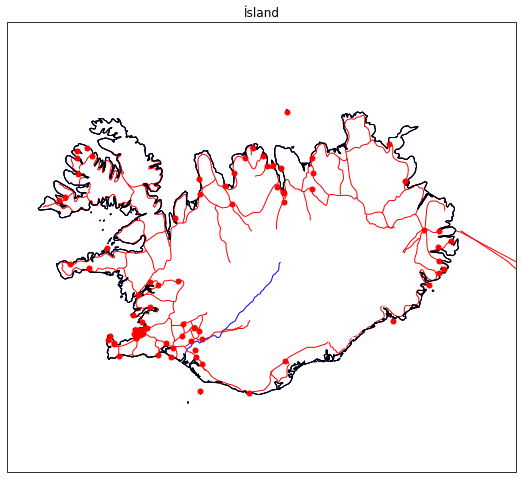

In [100]:
region_extent = iceland_extent
size=a4_landscape
plt.rcParams['svg.fonttype'] = 'none'

fig = plt.figure(figsize=(size))
fig.set_gid('ysti rammi')

ax = plt.axes(projection=ccrs.Mercator())
ax.set_extent(region_extent, crs=ccrs.PlateCarree())
ax.set_title('Ísland')
ax.set_gid('Ísland')

# drop points from df if out of range of region_extent
df = dataframe
df = df.drop(df[(df.longitude < region_extent[0]) | (df.longitude > region_extent[1]) | (df.latitude < region_extent[2]) | (df.latitude > region_extent[3])].index)

coast = cfeature.NaturalEarthFeature(category='physical', scale='10m', facecolor='none', name='coastline', edgecolor='black')
land = cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='black', facecolor='none')# facecolor=cfeature.COLORS['land'])
rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m',edgecolor='blue',facecolor='none')
glaciers = cfeature.NaturalEarthFeature(category='physical', name='glaciated_areas', scale='10m', edgecolor='white',facecolor='none')
roads = cfeature.NaturalEarthFeature('cultural', 'roads', '10m',edgecolor='red',facecolor='none')

rivers = ax.add_feature(rivers)
rivers.set_gid('rivers')

roads = ax.add_feature(roads)
roads.set_gid('roads')

ocean = ax.add_feature(cartopy.feature.OCEAN,edgecolor='blue',facecolor='none')
ocean.set_gid('ocean')

# ax.add_feature(cartopy.feature.LAND, edgecolor='black')
land = ax.add_feature(land)
land.set_gid('land')

glaciers = ax.add_feature(glaciers)
glaciers.set_gid('glaciers')

coast = ax.add_feature(coast)
coast.set_gid('coast')

# ax.coastlines()
artists = ax.properties()['default_bbox_extra_artists']
a = artists[0]
# print(dir(a))
# print(dir(a.get_transformed_clip_path_and_affine()))

def recursivechildren(arr):
    for val in arr:
        val.set_gid('lalalalala')
        if('get_children' in dir(val)):
            recursivechildren(val.get_children())
recursivechildren(fig.get_children()[1].get_children())

# for c in fig.get_children()[1].get_children():
#     print(c.get_children())
#     c.set_gid('whatererksjdla')

# for a in artists[:-1]:
# for a in artists[:-1]:
    # print(a.patches)
    # print(a.properties())
    # print(dir(a.properties()['clip_path']))
    # print(a.properties()['clip_path'][5])
    # print(a.properties()['figure'].get_gid())
    # a.set_label('lol')
    # print(a.get_gid())
# for i in range(len(artists)-1):
#     print(artists[i])
#     print(artists[i])


# plot swimming pools as red dots
plt.plot(df['longitude'],df['latitude'],df['name'],
         color='red', marker='o',
         markersize=5,
         linestyle="None",
         transform=ccrs.Geodetic(),
         )

#pool names
transform = ccrs.Mercator()._as_mpl_transform(ax)
# for index, obj in df.iterrows():
#     if(obj['latitude'] > 0):
#         ax.text(obj['longitude'],obj['latitude'], obj['name'], color='black', size=5, ha='center', va='center', transform=ccrs.PlateCarree())#, 

# plt.gca().set_axis_off() #to remove border

fig.set_clip_box(ax.get_window_extent())
plt.savefig('island-allt.svg')
plt.show()

In [ ]:
xt = capital_region_extent
# x = (xt[0]-3, xt[1]-3, xt[2]+3, xt[3]+3)
# print(x)
create_map(region_extent=x,title='lol',name='nettinetti')